<a href="https://colab.research.google.com/github/ArielKatzir/LLM_EncoderDecoder_Translator_PyTorch/blob/master/LLM_basic_encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Scale Encoder Decoder LLM Translating English to Italian
### Made from scratch - i.e. no Huggingface.Transformers. Only PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install sacrebleu

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.0 MB/s eta 0:00:00




First we download and load the data

In [2]:
import math
import random
import sacrebleu
import torch

import numpy as np
import pandas as pd
import sentencepiece as spm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# data downloaded from https://tatoeba.org/en/downloads
raw_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/english_italian.tsv', sep='\t', on_bad_lines='skip')
raw_df.shape, raw_df.head(1)

((681865, 4),
    1276    Let's try something.  565618      Proviamo qualcosa!
 0  1277  I have to go to sleep.  4369.0  Devo andare a dormire.)

Tokanise - we will need to train the tokaniser first. It is in the format of a .txt file where one sentance is in english and the line after will have the translation. For this ill need to use maybe 100k samples.

In [3]:
t_english = np.array(raw_df[raw_df.columns[1]])
t_italian = np.array(raw_df[raw_df.columns[3]])

# make random boolean mask
mask = np.random.rand(t_english.shape[0]) > 0.95

# Apply mask to get valid indices
masked_indices = np.where(mask)[0]
assert len(t_english) == len(t_italian), "Mismatched lengths!"

t_eng_sample = t_english[masked_indices][:30000] # just to have a round number
t_ita_sample = t_italian[masked_indices][:30000]

t_eng_sample.shape, t_ita_sample.shape

((30000,), (30000,))

In [4]:
# save txt file for tokanizer training data
with open("english_italian_tokanizer.txt", "w", encoding="utf-8") as f:
    for en, it in zip(t_eng_sample, t_ita_sample):
        f.write(en.strip() + "\n")
        f.write(it.strip() + "\n\n")

In [5]:
# train byte pair encoding (bpe) which learns tokens better by breaking
# down words into relevant chunks. Vocab size 8000 is good for around 150000
spm.SentencePieceTrainer.train(
    input='english_italian_tokanizer.txt',
    model_prefix='bpe',
    vocab_size=8000,
    character_coverage=1.0,   # use 0.9995 for non-Latin languages
    model_type='bpe',          # or 'unigram', 'word', 'char'
    pad_id=0, pad_piece='<pad>',
    unk_id=1, unk_piece='<unk>',
    bos_id=2, bos_piece='<s>',
    eos_id=3, eos_piece='</s>'
)

In [6]:
# load tokaniser and try it out
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("bpe.model")
# english and italian
encoded = tokenizer.encode("ciao come stai? And also, how are you?", out_type=int)
encoded

[10, 5206, 337, 1762, 7912, 1238, 3415, 7917, 1036, 199, 40, 7912]

Now lets take our training data sample. Make it small coz we dont have much GPU power.

In [7]:
MAX_LEN = 50
sos_id = tokenizer.piece_to_id('<s>')
eos_id = tokenizer.piece_to_id('</s>')
pad_id = tokenizer.piece_to_id('<pad>')
unk_id = tokenizer.unk_id()
encoded = tokenizer.encode("ciao come stai? And also, how are you?", out_type=int)
encoded

[10, 5206, 337, 1762, 7912, 1238, 3415, 7917, 1036, 199, 40, 7912]

We create a class where we can fetch tokenized input/target pair - includes padding.

In [8]:
class TranslationDataset(Dataset):
  def __init__(self, src_sentences, tgt_sentences, tokenizer, max_len):
    self.src = src_sentences
    self.tgt = tgt_sentences
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.src)

  # this method is required for a Dataset subclass
  def __getitem__(self, idx):

    # encode english and italian indices from the training data
    src_ids = self.tokenizer.encode(self.src[idx], out_type=int)
    tgt_ids = self.tokenizer.encode(self.tgt[idx], out_type=int)

    # ensure max length is enforced for consistancy
    src_ids = src_ids[:self.max_len]

    # here we must to add start and end of sentance to tell the model when to
    # start and stop generating output
    tgt_ids = [sos_id] + tgt_ids[:self.max_len - 2] + [eos_id]

    # add padding to ensure both input and output have exactly max_length context
    src_ids += [pad_id] * (self.max_len - len(src_ids))
    tgt_ids += [pad_id] * (self.max_len - len(tgt_ids))

    return {
        'src': torch.tensor(src_ids, dtype=torch.long),
        'tgt': torch.tensor(tgt_ids, dtype=torch.long)
    }



We now need to define the layers.

In [9]:
class Embeddings(nn.Module):
  def __init__(self, vocab_size, d_model, max_len):
    super().__init__()
    self.token_embed = nn.Embedding(vocab_size, d_model)
    self.pos_embed = nn.Embedding(max_len, d_model)
  def forward(self, x):
    positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
    return self.token_embed(x) + self.pos_embed(positions)

In [10]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model, heads):
    super().__init__()

    # creates Q,K,V projected inputs and returns the attention matrix
    self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)

    self.ln1 = nn.LayerNorm(d_model)
    # fast forward
    self.ffn = nn.Sequential(
        nn.Linear(d_model, 4*d_model),
        nn.GELU(),
        nn.Dropout(0.1),
        nn.Linear(4*d_model, d_model),
        nn.Dropout(0.1)
    )
    self.ln2 = nn.LayerNorm(d_model)

  def forward(self, x):
    # input is of dim: (B,T,d_model)
    B, T, _ = x.shape

    # No masking is needed here because its the encoder

    attn_output, _ = self.attn(x, x, x)
    x = self.ln1(x + attn_output)
    x = self.ln2(x + self.ffn(x))
    return x

In [11]:
class DecoderBlock(nn.Module):
  def __init__(self, d_model, heads):
    super().__init__()
    # this is attention of the decoder input, it only looks at the previous tokens
    self.self_attn = nn.MultiheadAttention(d_model, heads, batch_first=True)

    # this is attention which includes information from the decoder, which gathered
    # information from the entire sequence. Basically remembers.
    self.cross_attn = nn.MultiheadAttention(d_model, heads, batch_first=True)

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)

    self.ffn = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.GELU(),
        nn.Dropout(0.1),
        nn.Linear(4 * d_model, d_model),
        nn.Dropout(0.1)
    )

  def forward(self, x, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
    # notice here that every time we normalise the layer we do it on the residual connection.

    self.attn_output, _ = self.self_attn(x, x, x, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
    x = self.ln1(x + self.attn_output)

    cross_attn_output, _ = self.cross_attn(x, memory, memory, key_padding_mask=memory_key_padding_mask)
    x = self.ln2(x + cross_attn_output)

    x = self.ln3(x + self.ffn(x))

    return x

We can now wrap all these three blocks into one wrapper

In [12]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, max_len, num_blocks):
        super().__init__()

        # create embeddings for encoder and decoder
        self.src_embed = Embeddings(vocab_size, d_model, max_len)
        self.tgt_embed = Embeddings(vocab_size, d_model, max_len)

        # lists of encoder and decoder blocks
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(d_model, n_heads) for _ in range(num_blocks)
        ])

        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads) for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # src: [B, S]
        # tgt: [B, T]

        # make the embeddings from the tokens
        src_embedded = self.src_embed(src)  # [B, S, d_model]
        tgt_embedded = self.tgt_embed(tgt)  # [B, T, d_model]

        # pass through the encoder stack in series
        memory = src_embedded
        for block in self.encoder_blocks:
            memory = block(memory)  # [B, S, d_model]

        # pass through decoder stack
        x = tgt_embedded
        for block in self.decoder_blocks:
            x = block(x, memory, tgt_mask, tgt_key_padding_mask, memory_key_padding_mask)

        logits = self.output_layer(x)

        # Final output projection is done inside each decoder block
        return logits

OK cool! Now the model architecture is finished. We have an encoder and a decoder model. We can start building the training loop. The idea is that we feed a source sentance in english to the encoder, the encoder comes up with a contextual memory matrix, which feeds into the decoder as input along with the original input, and the decoder, hopfully, comes up with a logits distribution which can help choose a translation. For example:
- src: "How are you?"
- DIn: "<'bos'> come stai?"
- Dout: "come stai? <'eos'>"

In [13]:
# config
vocab_size = 8000       # should be enough
d_model = 128          # embedding size - needs to be divisible by n_heads
n_heads = 8           # 4 attention heads
max_len = 50           # max sequence length - i didnt see anything which should get anywhere near this but safety
num_blocks = 4        # transformer blocks
batch_size = 32
epochs = 20

# but do we even have a GPU???
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
# init the model
model = EncoderDecoderModel(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    max_len=max_len,
    num_blocks=num_blocks
).to(device)

In [15]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_params:,}")

Trainable parameters: 4,944,192


Fetch random data - ensure small scale - colab gpu weakkk

In [16]:
# ensure each sentance is a string (some arent somehow)
all_english = np.array([str(s) for s in t_english.tolist()])
all_italian = np.array([str(s) for s in t_italian.tolist()])

# randomly make a ~5% bool mask and then cap to 30k for training
mask = np.random.rand(len(all_english)) > 0.5
candidate_idxs = np.where(mask)[0]
train_idxs     = candidate_idxs[:30000]

train_en = all_english[train_idxs]
train_it = all_italian[train_idxs]

# everything else → hold‐out pool
remaining_idxs = np.setdiff1d(np.arange(len(all_english)), train_idxs)

# split remaining into val and test - 50/50
val_idxs, test_idxs = train_test_split(
    remaining_idxs,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

max_test_val = 5000

val_en  = all_english[val_idxs][:max_test_val]
val_it  = all_italian[val_idxs][:max_test_val]
test_en = all_english[test_idxs][:max_test_val]
test_it = all_italian[test_idxs][:max_test_val]

train_en.shape, train_it.shape, val_en.shape, val_en.shape, test_en.shape, test_en.shape

((30000,), (30000,), (5000,), (5000,), (5000,), (5000,))

In [17]:
# init the data loader
train_dataset = TranslationDataset(
    src_sentences=train_en,
    tgt_sentences=train_it,
    tokenizer=tokenizer,
    max_len=max_len
)

In [18]:
# create a data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True   #  drops last incomplete batch
)

In [19]:
# just a function to make a triangle mask for the decoder
def generate_causal_mask(size: int, device: torch.device = None):
    # returns a matrix mask with -inf above the diagonal, 0.0 on and below
    mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1)
    if device is not None:
        mask = mask.to(device)
    return mask

In [20]:
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id)  # ignores <pad> tokens
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

training_losses = []
for epoch in range(epochs):

    model.train() # enter training mode
    total_loss = 0

    for batch in train_loader:
        src = batch['src'].to(device)  # [B, S]
        tgt = batch['tgt'].to(device)  # [B, T]

        tgt_input = tgt[:, :-1]  # remove last token for decoder input
        tgt_output = tgt[:, 1:]  # remove first token for decoder output

        # generate masks for decoder and pads
        tgt_mask = generate_causal_mask(tgt_input.size(1), device)
        tgt_key_padding_mask = (tgt_input == pad_id)
        memory_key_padding_mask = (src == pad_id)

        # pass in the network
        logits = model(src, tgt_input,
                       tgt_mask=tgt_mask,
                       tgt_key_padding_mask=tgt_key_padding_mask,
                       memory_key_padding_mask=memory_key_padding_mask)

        # reshape for loss because CrossEntropyLoss expects a plattend B*T rather than (B,T,vocab)
        logits = logits.reshape(-1, vocab_size)        # [(B*T), vocab]
        tgt_output = tgt_output.reshape(-1)            # [(B*T)]

        loss = loss_fn(logits, tgt_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")
    training_losses.append(avg_loss)


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1: loss = 6.0486
Epoch 2: loss = 5.0227
Epoch 3: loss = 4.4874
Epoch 4: loss = 4.0570
Epoch 5: loss = 3.6889
Epoch 6: loss = 3.3672
Epoch 7: loss = 3.0799
Epoch 8: loss = 2.8268
Epoch 9: loss = 2.5964
Epoch 10: loss = 2.3882
Epoch 11: loss = 2.1980
Epoch 12: loss = 2.0283
Epoch 13: loss = 1.8704
Epoch 14: loss = 1.7310
Epoch 15: loss = 1.6017
Epoch 16: loss = 1.4850
Epoch 17: loss = 1.3743
Epoch 18: loss = 1.2762
Epoch 19: loss = 1.1854
Epoch 20: loss = 1.0988


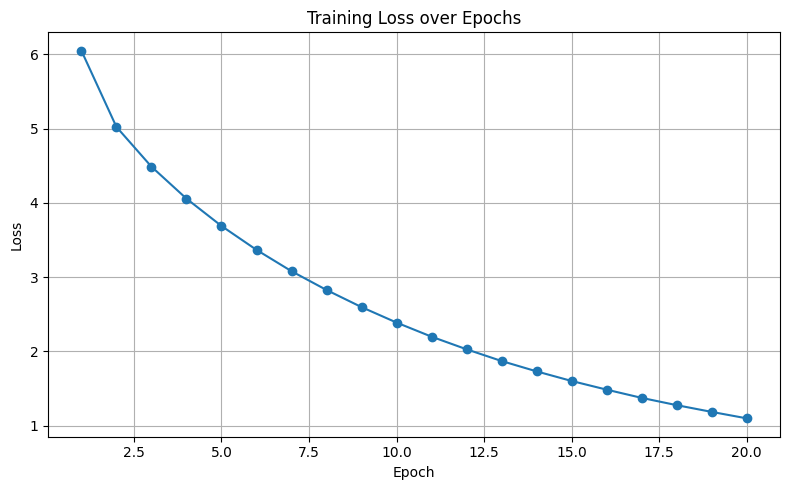

In [21]:
# plot loss over time
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(training_losses)+1), training_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

Now the loss goes down, and can go down more. But alone it might not mean much.
Ideally, we should have added validation code in the main loop. But for educational purposes i want to look at the results of this model and how it performs, and later we do it again with validation to see the effect it has.  

# Inference (Greedy Decoding) - aka Autoregressively decoding
So now we only have the source english.
You need to generate the target tokens one by one:
Run the encoder on src → get memory.

Initialize your decoder input with just <"sos"> char.

Run the decoder on that to get logits → pick the highest-score token → append to your sequence.

Repeat: feed this longer sequence back into the decoder (with the same memory) to get the next token.

Stop when you generate <"eos"> or reach max_len.

Because this is a loop (“for step in 1…max_len”), and because you have to interleave model.forward calls with argmax and append, we wrap it up in a separate translate() function.

In [22]:
def inference(model, src_sentence: str, tokenizer, max_len: int):
    # pass an input into the trained network to get the translation
    model.eval()
    with torch.no_grad():

        # tokanise the source sentence, add padding if needed, move to gpu
        src_ids = tokenizer.encode(src_sentence, out_type=int)
        src_ids = src_ids[:max_len] + [pad_id] * (max_len - len(src_ids))
        src_tensor = torch.tensor([src_ids], device=device)

        # create embedding, pass in the encoder.
        memory = model.src_embed(src_tensor)
        for blk in model.encoder_blocks:
            memory = blk(memory)

        # decode repeatidly on generated outputs until the <eos> is reached
        tgt_ids = [sos_id]

        # to max sequence length
        for _ in range(max_len):

            # build decoder input with paddings, move to gpu
            decoder_input = tgt_ids + [pad_id] * (max_len - len(tgt_ids))
            tgt_tensor = torch.tensor([decoder_input], device=device)

            # apply all decoder blocks
            x = model.tgt_embed(tgt_tensor)
            tgt_mask = generate_causal_mask(x.size(1), device)
            for blk in model.decoder_blocks:
                x = blk(x, memory,
                        tgt_mask=tgt_mask,
                        tgt_key_padding_mask=(tgt_tensor == pad_id),
                        memory_key_padding_mask=(src_tensor == pad_id))

            # project to vocab and take highest‐scoring token
            logits = model.output_layer(x)  # [1, T, vocab_size]
            next_id = logits[0, len(tgt_ids)-1].argmax().item()
            tgt_ids.append(next_id)
            # stop generating tokens from decoder if this is met
            if next_id == eos_id:
                break

        # drop the initial <s> and any padding
        return tokenizer.decode(
            [tid for tid in tgt_ids[1:] if tid not in {pad_id, eos_id}],
            out_type=str
        )


In [23]:
test_dataset = TranslationDataset(test_en, test_it, tokenizer, max_len)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
# we use shuffle=False so we can reproduce the same tests

Run test loop

In [24]:
all_preds, all_refs = [], []

with torch.no_grad():
    for batch in test_loader:
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)
        tgt_input, tgt_output = tgt[:,:-1], tgt[:,1:]

        # run model, compute loss as before
        for i in range(src.size(0)):

            # decode and clean up the source: we do this for convenience, so
            # you can call inference on a model and a string.
            raw_src_ids = src[i].tolist()
            src_ids = [tid for tid in raw_src_ids if tid != pad_id]
            src_text = tokenizer.decode(src_ids, out_type=str)

            # run inference, aka, translate the sentance
            pred = inference(model, src_text, tokenizer, max_len)
            all_preds.append(pred)

            # build the reference string from tgt_output:
            raw_ref_ids = tgt_output[i].tolist()
            ref_ids = [tid for tid in raw_ref_ids if tid not in {pad_id, eos_id}]
            ref = tokenizer.decode(ref_ids, out_type=str)
            all_refs.append(ref)

In [25]:
all_preds = np.array(all_preds)
all_refs = np.array(all_refs)
all_preds.shape, all_refs.shape

((5000,), (5000,))

#### Ok so now we have our predictions, we need to measure how good they are.

In [26]:
# bleu
bleu = sacrebleu.corpus_bleu(all_preds.tolist(), [all_refs.tolist()])
print(f"Test BLEU = {bleu.score:.2f}")

Test BLEU = 16.12
